<a href="https://colab.research.google.com/github/nilanahar/MMAI_894_DeepLearning_Project_TeamRosedale/blob/main/MMAI_894_Team_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

#### Packages to Load

In [51]:
from google.colab import drive
import pandas as pd
import numpy as np
import json
import joblib
import os
import re
import ast

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy


import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# define my google drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Step 1: Data Collection

#### Set Directories

In [ ]:
# Define the file path (adjust it to match your folder structure)
training_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/MultipleChoice_abstract_v002_train2015_questions.json"
training_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/OpenEnded_abstract_v002_train2015_questions.json"
training_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/abstract_v002_train2015_annotations.json"
training_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Training/Data/scene_img_abstract_v002_train2015"

validation_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/MultipleChoice_abstract_v002_val2015_questions.json"
validation_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/OpenEnded_abstract_v002_val2015_questions.json"
validation_answers_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/abstract_v002_val2015_annotations.json"
validation_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Validation/Data/scene_img_abstract_v002_val2015"

testing_mcq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/MultipleChoice_abstract_v002_test2015_questions.json"
testing_oeq_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/OpenEnded_abstract_v002_test2015_questions.json"
testing_images_file_path = "/content/drive/MyDrive/Colab Notebooks/894/Testing/Data/scene_img_abstract_v002_test2015"

#### Functions to Use in Step 1 (Must Run)

In [ ]:
# Function to load multiple JSON data
def load_json(file_path):
    if file_path: # Check if file_path is not None
        with open(file_path, 'r') as f:
            return json.load(f)
    else:
        return None # or handle the None case differently, like returning an empty dictionary

def json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path):
    # Now you can use this function to load multiple JSON files
    mcq_json_data = load_json(mcq_file_path)
    oeq_json_data = load_json(oeq_file_path)

    mcq_df = pd.json_normalize(mcq_json_data['questions'])[['image_id', 'question_id', 'question', 'multiple_choices']]
    oeq_df = pd.json_normalize(oeq_json_data['questions'])[['image_id', 'question_id', 'question']]

    # Check if answers_file_path is None
    if answers_file_path is not None:
        answers_json_data = load_json(answers_file_path)
        answers_df = pd.json_normalize(answers_json_data['annotations'])[['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type']]
    else:
        # Create an empty DataFrame if answers_file_path is None
        answers_df = pd.DataFrame(columns=['image_id', 'question_id', 'question_type', 'answers', 'multiple_choice_answer', 'answer_type'])

    return mcq_df, oeq_df, answers_df


def tabularize_answers_df(answers_df):
    # Create a unique identifier for each row to track back after transformations
    answers_df['index'] = answers_df.index
    # Explode the 'answers' column into separate rows, while keeping other columns intact
    answers_expanded_df = answers_df.explode('answers')
    # normalization as before
    answers_details = pd.json_normalize(answers_expanded_df['answers'])
    answers_details['index'] = answers_expanded_df.index
    # Concatenate back to the actual answers DataFrame
    answers_expanded_df = pd.merge(answers_df, answers_details, on='index', how='left')
    answers_merged_df = answers_expanded_df[['image_id', 'question_id', 'question_type',
                                              'multiple_choice_answer', 'answer_type',
                                              'answer', 'answer_id', 'answer_confidence',
                                              'index']]
    answers_merged_df = answers_merged_df.rename(columns={'multiple_choice_answer': 'mcq_answer',
                                                              'answer_type': 'mcqa_type',
                                                              'answer': 'oeq_answer',
                                                              'answer_id': 'oeqa_id',
                                                              'answer_confidence': 'oeqa_confidence'
                                                              })

    return answers_merged_df

# Function to extract features from multiple JSON files
def extract_qna_features(mcq_file_path, oeq_file_path, answers_file_path):

    mcq_df, oeq_df, answers_df = json_to_pdDf(mcq_file_path, oeq_file_path, answers_file_path)
    answers_merged_df = tabularize_answers_df(answers_df)

    questions_merged_df = pd.merge(mcq_df, oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
    final_qna_df = pd.merge(questions_merged_df, answers_merged_df, on=['image_id', 'question_id'], how='left')

    return mcq_df, oeq_df, answers_merged_df, final_qna_df


# Function to extract last five digits from file names
def extract_last_five_digits(filename):
    match = re.search(r'(\d{5})\.png$', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern.")

def extract_image_features(model, images_file_path):
    images_features_dict = {}
    for img_name in tqdm(os.listdir(images_file_path)):
        img_path = os.path.join(images_file_path, img_name)

        # Extract image_id (adjust slice according to your filename structure)
        image_id = img_name[-9:-4]  # Example: extracting last 5 digits before file extension

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

        # Extract features and store them in the dictionary
        features = model.predict(x)
        images_features_dict[image_id] = features.flatten()

    images_features_df = pd.DataFrame.from_dict(images_features_dict, orient='index')
    images_features_df.reset_index(inplace=True)
    images_features_df.rename(columns={'index': 'image_id'}, inplace=True)

    return images_features_df


def complete_datasets(qna_df, images_features_df):
    qna_df = qna_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df = images_features_df.sort_values(by='image_id').reset_index(drop=True)
    images_features_df['image_id'] = images_features_df['image_id'].astype(int)
    # Merge the 3 dataframes into one (base dataset is image_df (unique), left join qna on image id)
    complete_training_set = pd.merge(images_features_df, qna_df, on='image_id', how='left')
    return complete_training_set


#### Define Constants

In [5]:
### Load the pre-trained model that you wish to use to extract image features ###
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 1.1 Training Datasets

#### 1.1.1 Extracting Questions & Answers

In [ ]:
train_mcq_df, train_oeq_df, train_answers_merged_df, train_final_qna_df = extract_qna_features(training_mcq_file_path, training_oeq_file_path, training_answers_file_path)
train_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,old person,1,maybe,0
1,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,2,maybe,0
2,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,3,yes,0
3,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,man,4,yes,0
4,11779,117792,Who looks happier?,"[alive, 1, woman, purple, 2, yes, white, boy, ...",Who looks happier?,who,man,other,old man,5,yes,0


##### Save Workspace

In [ ]:
# Save the dataframes to Google Drive
joblib.dump(train_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib']

#### 1.1.2 Extracting Images' Features


In [ ]:
train_images_features_df = extract_image_features(model, training_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(train_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")

#### 1.1.3 Complete Training Dataset

##### Load Workspace

In [ ]:
train_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/questions_answers_features.joblib")
train_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/images_features.joblib")
train_images_df.shape

(20000, 2049)

In [ ]:
train_complete_df = complete_datasets(train_qna_df, train_images_df)
train_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,7,yes,13752
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,beige,8,yes,13752
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,tan,9,yes,13752
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,10,yes,13752
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,monkey bars,other,monkey bars,1,yes,13753


##### Save Workspace

In [ ]:
joblib.dump(train_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib']

### 1.2 Validation Datasets

#### 1.2.1 Extracting Questions & Answers


In [ ]:
valid_mcq_df, valid_oeq_df, valid_answers_merged_df, valid_final_qna_df = extract_qna_features(validation_mcq_file_path, validation_oeq_file_path, validation_answers_file_path)
valid_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,1,yes,0
1,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,2,maybe,0
2,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,3,yes,0
3,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,4,yes,0
4,27578,275780,Is the dog asleep?,"[white, picnicking, yes, hot, dog and girl, bl...",Is the dog asleep?,is the dog,yes,yes/no,yes,5,yes,0


##### Save Workspace

In [ ]:
joblib.dump(valid_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib']

#### 1.2.2 Extracting Images' Features

In [ ]:
valid_images_features_df = extract_image_features(model, validation_images_file_path)

In [ ]:
valid_images_features_df.shape

##### Save Workspace

In [ ]:
joblib.dump(valid_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")

#### 1.2.3  Complete Validation Dataset

##### Load Workspace

In [ ]:
valid_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/questions_answers_features.joblib")
valid_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/images_features.joblib")
valid_images_df.shape

(10000, 2049)

In [ ]:
valid_complete_df = complete_datasets(valid_qna_df, valid_images_df)
valid_complete_df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,8,yes,22585
1,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,9,yes,22585
2,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,10,yes,22585
3,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the curtains match?,"[smiling, 4, for fun, no, forest, 3, sandwich ...",Do the curtains match?,do the,yes,yes/no,yes,1,yes,22586
4,20000,0.874148,0.477496,0.066509,0.95172,0.075566,2.393809,1.363019,0.398546,2.833386,...,Do the windows appear dirty?,"[4, 3, above fireplace, brown, yes, 1, no, beh...",Do the windows appear dirty?,do the,no,yes/no,no,6,yes,22585


##### Save Workspace

In [ ]:
joblib.dump(valid_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib']

### 1.3 Testing Datasets

#### 1.3.1 Extracting Questions & Answers

In [ ]:
test_mcq_df, test_oeq_df, test_answers_df = json_to_pdDf(testing_mcq_file_path, testing_oeq_file_path, None)
test_final_qna_df = pd.merge(test_mcq_df, test_oeq_df, on=['image_id', 'question_id'], how='left', suffixes=('_oeq', '_mcq'))
test_final_qna_df.head()

,image_id,question_id,question_oeq,multiple_choices,question_mcq
0,39456,394560,What color are the chairs?,"[red, 4, 3, plates, brown, yellow, green, stan...",What color are the chairs?
1,39456,394561,Is the man asleep?,"[3, blue, 4, no, anger, white, 2, red, yes, on...",Is the man asleep?
2,39456,394562,What is on the table?,"[white, on sidewalk, salt and pepper, 3, yes, ...",What is on the table?
3,47922,479220,How many bushes are in the background?,"[blue, 1, 3, 40, dog, 10, 2, sun rays, red, ye...",How many bushes are in the background?
4,47922,479221,What are they playing?,"[yes, soccer, on man's head, frisbee, golf, mo...",What are they playing?


##### Save Workspace

In [ ]:
joblib.dump(test_final_qna_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib']

#### 1.3.2 Extracting Images' Features

In [ ]:
test_images_features_df = extract_image_features(model, testing_images_file_path)

##### Save Workspace

In [ ]:
joblib.dump(test_images_features_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")

#### 1.3.3 Complete Testing Dataset

##### Load Workspace

In [ ]:
test_qna_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/questions_answers_features.joblib")
test_images_df = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Testing/images_features.joblib")
test_images_df.shape

In [ ]:
test_complete_df = complete_datasets(valid_qna_df, valid_images_df)
test_complete_df.head()

##### Save Workspace

In [ ]:
joblib.dump(test_complete_df, "/content/drive/MyDrive/Colab Notebooks/894/Testing/complete_testing_set_tabular.joblib")









<space>

# Step 2: Data Preprocessing

### 2.1 Exploratory Data Analysis (EDA)

##### Load Workspace

In [3]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/complete_training_set_tabular.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/complete_validation_set_tabular.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_oeq,multiple_choices,question_mcq,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,7,yes,13752
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,beige,8,yes,13752
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,tan,9,yes,13752
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,What color is the ladies pants?,"[1, 3, brown, wildlife, not having tv, yellow,...",What color is the ladies pants?,what color is the,tan,other,brown,10,yes,13752
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,How is the equipments with bars called?,"[get warm, yes, playful, pug, red, fitness sys...",How is the equipments with bars called?,how,monkey bars,other,monkey bars,1,yes,13753


##### Functions to Use in Step 2 (Must Run)

In [13]:
def preprocess_text(text):
    """
    Improved text preprocessing function that retains context and meaning.
    - Converts text to lowercase.
    - Removes non-alphabetic characters.
    - Tokenizes, removes only non-essential stopwords, and lemmatizes.
    """
    if pd.isnull(text):
        return ''

    # Convert text to lowercase
    text = text.lower()
    # Remove non-alphabetic characters (but keep question marks and spaces)
    text = re.sub(r'[^a-z\s\?]', '', text)
    # Tokenize text into words
    words = text.split()
    # Create a lemmatizer object
    lemmatizer = WordNetLemmatizer()
    # Define stop words
    stop_words = set(stopwords.words('english')) # Define stop_words here
    essential_stopwords = {"how", "how many", "what", "when", "why", "which", "where", "who"}
    # Remove stopwords, but retain essential question words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words or word in essential_stopwords]
    # Join words back into a single string
    return ' '.join(words)


def filter_choices_by_cosine_similarity(row):
  # Step 1: initialize
    question = row['question']
    choices = row['multiple_choices']  # Assume 'multiple_choices' column has a list of answer options

    # Convert question and choices into a single corpus
    corpus = [question] + choices

    # Step 2: Vectorize the corpus using TF-IDF
    vectorizer = TfidfVectorizer().fit(corpus)  # Fit on the full corpus
    vectors = vectorizer.transform(corpus).toarray()  # Transform into TF-IDF vectors

    # Step 3: Calculate cosine similarity between the question and each choice
    similarity_scores = cosine_similarity([vectors[0]], vectors[1:])[0]

    # Step 4: Retain choices with a high similarity score (e.g., > 0.3)
    threshold = 0.3
    filtered_choices = [choices[i] for i, score in enumerate(similarity_scores) if score >= threshold]

    # Step 5: If no choices pass the threshold, keep original choices to avoid empty options
    return filtered_choices if filtered_choices else choices



##### Questions' Length Visualization

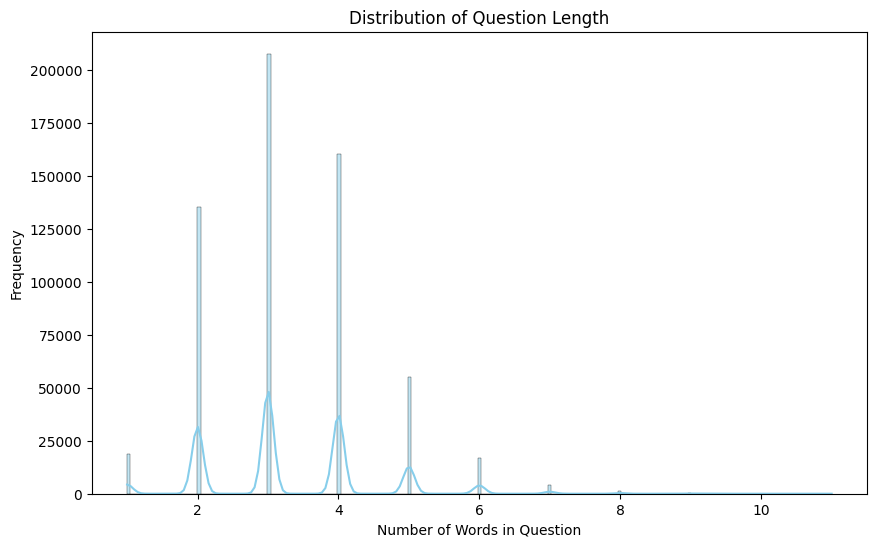

In [22]:
# Analyze Question Length
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_train['question_length'], kde=True, color='skyblue')
plt.title('Distribution of Question Length')
plt.xlabel('Number of Words in Question')
plt.ylabel('Frequency')
plt.show()

##### Questions' Common Words

In [23]:
# Most common words in question
question_text = df_train['question']
question_words = question_text.split()
word_counts = Counter(question_words)
common_words = word_counts.most_common(20)
print("\nMost Common Words in Questions:")
for word, count in common_words:
    print(f"{word}: {count}")


Most Common Words in Questions:
what: 200120
how: 90590
many: 85330
color: 57540
man: 38850
woman: 38170
girl: 33350
where: 31670
boy: 28980
dog: 24490
there?: 18730
sitting: 17480
people: 16270
doing?: 15270
cat: 14970
on?: 13630
lady: 13150
animal: 13150
table?: 12600
playing: 11560


##### Keeping only one question column since question_oeq = question_mcq

In [5]:
# Check if two specific columns are identical in the DataFrame
are_questions_columns_equal = df_train['question_oeq'].equals(df_train['question_mcq'])  # Replace 'question_x' and 'question_y' with your actual column names

# Print the result
print("Are 'question_oeq' and 'question_mcq' identical? : ", "Yes" if are_questions_columns_equal else "No")

Are 'question_oeq' and 'question_mcq' identical? :  Yes


In [6]:
df_train['question'] = df_train['question_oeq']
df_valid['question'] = df_valid['question_oeq']

df_train = df_train.drop(columns=['question_oeq', 'question_mcq'])
df_valid = df_valid.drop(columns=['question_oeq', 'question_mcq'])

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_2.1.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique.joblib']

##### Save Workspace

In [ ]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_unique_2.2.joblib']

### 2.2 Feature Engineering

##### Load Workspace

In [53]:
df_train = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Training/(1)_dfTrain_unique_2.1.joblib")
df_valid = joblib.load("/content/drive/MyDrive/Colab Notebooks/894/Validation/(1)_dfValid_unique_2.1.joblib")
df_train.head()

,image_id,0,1,2,3,4,5,6,7,8,...,question_id,multiple_choices,question_type,mcq_answer,mcqa_type,oeq_answer,oeqa_id,oeqa_confidence,index,question
0,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,brown,7,yes,13752,What color is the ladies pants?
1,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,beige,8,yes,13752,What color is the ladies pants?
2,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,tan,9,yes,13752,What color is the ladies pants?
3,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,0,"[1, 3, brown, wildlife, not having tv, yellow,...",what color is the,tan,other,brown,10,yes,13752,What color is the ladies pants?
4,0,0.037811,1.084643,0.125582,2.314969,0.325828,0.302625,0.976951,0.753177,0.227697,...,1,"[get warm, yes, playful, pug, red, fitness sys...",how,monkey bars,other,monkey bars,1,yes,13753,How is the equipments with bars called?


##### Questions Text's Features' Engineering

In [21]:
# Apply the improved preprocessing function to the 'question' column
df_train['question_clean'] = df_train['question'].apply(preprocess_text)
df_valid['question_clean'] = df_valid['question'].apply(preprocess_text)
df_train[['question', 'question_clean']]

,question,question_clean
0,What color is the ladies pants?,what color lady pants?
1,What color is the ladies pants?,what color lady pants?
2,What color is the ladies pants?,what color lady pants?
3,What color is the ladies pants?,what color lady pants?
4,How is the equipments with bars called?,how equipment bar called?
...,...,...
599995,Is there a TV?,tv?
599996,Is there a TV?,tv?
599997,Is there a TV?,tv?
599998,Why does the boy have his hand on his head?,why boy hand head?


##### Answers Text's Features' Engineering

In [20]:
df_train['oeq_answer_clean'] = df_train['oeq_answer'].apply(preprocess_text)
df_valid['oeq_answer_clean'] = df_valid['oeq_answer'].apply(preprocess_text)
df_train[['oeq_answer', 'oeq_answer_clean']]

,oeq_answer,oeq_answer_clean
0,brown,brown
1,beige,beige
2,tan,tan
3,brown,brown
4,monkey bars,monkey bar
...,...,...
599995,yes,yes
599996,yes,yes
599997,yes,yes
599998,studying,studying


##### Multiple Choices List's Features' Engineering

In [ ]:
# Apply cosine similarity-based filtering to each row
df_train['filtered_multiple_choices'] = df_train.apply(filter_choices_by_cosine_similarity, axis=1)

In [49]:
df_train[['multiple_choices', 'filtered_multiple_choices', 'mcq_answer', 'oeq_answer']].head(1)

,multiple_choices,filtered_multiple_choices,mcq_answer,oeq_answer
0,"[1, 3, brown, wildlife, not having tv, yellow,...","[1, 3, brown, wildlife, not having tv, yellow,...",tan,brown


##### Save Workspace

In [45]:
joblib.dump(df_train, "/content/drive/MyDrive/Colab Notebooks/894/Training/(2)_dfTrain_unique_2.2.joblib")
joblib.dump(df_valid, "/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_unique_2.2.joblib")

['/content/drive/MyDrive/Colab Notebooks/894/Validation/(2)_dfValid_unique_2.2.joblib']